# Spatial Temporal Clustering of 2019 Teil Quake Tweets
---

This code relies on the ST-DBSCAN algorithm, which is a spatial-temporal clustering algorithm. It is based on the DBSCAN algorithm, but with the addition of a temporal component dimension. We have used the following implementation [ST-DBSCAN](https://github.com/eren-ck/st_dbscan). Please read the following paper for more information on the algorithm: [ST-DBSCAN: An algorithm for clustering spatial–temporal data](https://www.sciencedirect.com/science/article/pii/S0169023X06000218?via%3Dihub)

> **Keywords** Data mining, Cluster analysis, Spatial–temporal data, Cluster visualization

### Importing libraries

We use these libraries as following:
- **pandas** for data manipulation ;
- **st_dbscan** for clustering and **matplotlib** for plotting.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from st_dbscan import ST_DBSCAN
from prettytable import PrettyTable
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

# Set numpy print options
np.set_printoptions(suppress=True, precision=3)

# Use interactive matplotlib
%matplotlib widget

### Reading tweets dataset

In [2]:
# Read tweets
data_dir = os.path.realpath("../data")
tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data wrangling

The preprocessing is done in the following steps:
- Remove tweets with no location information ;
- Remove tweets that are not in France ;
- Convert time to pandas datetime ;
- Order tweets by datetime ;
- Remove columns that are not needed ;
- Create a new index for the data.

In [3]:
# Remove tweets with no coordinates
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
        (tweets.latitude > 42.33278)
    &   (tweets.latitude < 51.08917)
    &   (tweets.longitude > -4.795556)
    &   (tweets.longitude < +8.230556)
]

# Order tweets by datetime
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets.sort_values(by="createdAt", inplace=True)

# Remove columns that are not needed
try:
    tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'altitude', 'osm', 'geonames'], inplace=True)
except:
    pass

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

### Reprojecting tweets WGS → Lambert-93

Since we will be focusing on France, we will reproject the data to the Lambert Conformal Conic projection. This projection is used in France to represent the country on a flat map. We use the **geopandas** library to do this.

In [4]:
# Convert tweets to geodataframe
tweets = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude), crs="EPSG:4326")

# Project tweets to Lambert 93
tweets = tweets.to_crs("EPSG:2154")

# Calculate projected coordinates
tweets['x_m'] = tweets.geometry.x.round(3)
tweets['y_m'] = tweets.geometry.y.round(3)

# Reorder columns
tweets = tweets[['text', 'entity', 'wikidata', 'x_m', 'y_m', 'createdAt', 'geometry']]

In [5]:
tweets.head()

,text,entity,wikidata,x_m,y_m,createdAt,geometry
id,,,,,,,
1,il y a 23 min #seisme 2.0 a frappé Arbaz (Sion...,Arbaz,Q68113,1037421.834,6583455.288,2019-11-11 09:23:24+00:00,POINT (1037421.834 6583455.288)
2,Tremblement de terre à Lyon en ce moment !!!,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:46+00:00,POINT (843121.942 6519367.222)
3,#Séisme ressenti à #Lyon à l'instant,Lyon,Q456,843121.942,6519367.222,2019-11-11 10:53:56+00:00,POINT (843121.942 6519367.222)
4,Tremblement de terre en Ardèche à l'instant,Ardèche (département),Q3148,812290.663,6397402.763,2019-11-11 10:54:09+00:00,POINT (812290.663 6397402.763)
5,Wait ! Y’a des tremblements de terre en France...,France,Q142,624015.535,6656012.010,2019-11-11 10:54:18+00:00,POINT (624015.535 6656012.010)


### Spatial temporal clustering using ST-DBSCAN

We'll start by normalizing the data. We'll then use the ST-DBSCAN algorithm to cluster the data. We'll use the **ST_DBSCAN** library to do this.

In [6]:
# Scale coordinates to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(tweets[['x_m', 'y_m']])

# Convert datetime (in ns) to seconds, // (floor division) 10 ** 9 to get seconds
tweets['ts'] = (tweets['createdAt'].values.astype(np.int64) // 10 ** 9)
# Convert ts in tweets to cumulative seconds
tweets['ts'] -= tweets['ts'].min()

# ts, x_m_norm, y_m_norm
data = np.hstack((tweets['ts'].values.reshape(-1, 1), scaled))

# Will be used for plotting (we can't plot normalized coordinates)
COORDS = tweets.loc[:, ['x_m','y_m']].values

# Calculate all pairwise normalized distances
dist_norm = np.linalg.norm(data[:, np.newaxis, 1:] - data[np.newaxis, :, 1:], axis=-1)
dist_norm.sort(axis=1)

# Calculate all pairwise terrain distances
dist = np.linalg.norm(COORDS[:, np.newaxis, :] - COORDS[np.newaxis, :, :], axis=-1)
dist.sort(axis=1)

### Launch clustering

We'll draw descriptive statistics for an example with `eps1=0.1`, `eps2=10min` et `min_samples=22`.

In [7]:
# ST-DBSCAN Clustering
# Parameters
eps1 = 0.1 # Distance threshold
eps2 = 60*10 # Time threshold
min_samples = 22 # Minimum number of tweets in a cluster

# Calculate terrain distance threshold
eps1_terrain = (eps1 * dist[-1][-1]) / dist_norm[-1][-1]

# Run ST-DBSCAN
start = time.time()
st_dbscan = ST_DBSCAN(eps1 = eps1, eps2 = eps2, min_samples = min_samples, metric = 'euclidean').fit(data)
end = time.time()

# Print results
eps1_terrain = int(eps1_terrain)    
eps2 = int(eps2 / 60)

result = [
    ['eps1 (m)', 'eps2 (min)', 'MinPts', 'Time (s)', '# of clusters'],
    [eps1_terrain, eps2, min_samples, round(end - start, 2), len(set(st_dbscan.labels))]
]

table = PrettyTable(result[0])
table.add_row(result[1])
print(table)

# Add cluster column to tweets
tweets['cluster'] = st_dbscan.labels

# Create a multiindex
tweets.sort_values(by="cluster", inplace=True)
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.drop(columns=['cluster'], inplace=True)

+----------+------------+--------+----------+---------------+
| eps1 (m) | eps2 (min) | MinPts | Time (s) | # of clusters |
+----------+------------+--------+----------+---------------+
|  90159   |     10     |   22   |   1.67   |       5       |
+----------+------------+--------+----------+---------------+


### Create convex hull for each cluster

In order to assess the extent of the quake, we'll create a convex hull for each cluster. We'll use the **scipy.spatial** library to do this.

In [8]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['num_tweets', 'area_km2', 'start_time_ts', 'geometry'])

for cluster in set(st_dbscan.labels):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[st_dbscan.labels == cluster]
        # Add start time of the cluster
        start_time = tweets[tweets.index.get_level_values(0) == cluster]['ts'].min()
        # Create a convex hull
        try:
            hull = ConvexHull(points)
        except:
            continue
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'num_tweets': [len(points)],
            'start_time_ts': [start_time],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls['cluster'] = hulls['cluster'].astype(int)

hulls.set_crs(epsg=2154, inplace=True)

# Calculate the area of the hulls
hulls['area_km2'] = round(hulls['geometry'].area / 1_000_000, 2)

# Clusters with no hulls
u_set = set(tweets.index.get_level_values(0)) - set(hulls['cluster']) - {-1}
print(f"Clusters with hulls: {set(hulls['cluster'])}")
print("Clusters with no hulls: ", u_set)

# Remove tweet clusters with no hulls
tweets = tweets[~tweets.index.get_level_values(0).isin(u_set)]

# Restart cluster ids for clusters different than -1
tweets.reset_index('cluster', inplace=True)
tweets.loc[tweets['cluster'] != -1, 'cluster'] = tweets.loc[tweets['cluster'] != -1, 'cluster'].astype('category').cat.codes

# Recreate multiindex
tweets.set_index(pd.MultiIndex.from_tuples(list(zip(tweets['cluster'], range(1, len(tweets) + 1))), names=["cluster", "tweet_id"]), inplace=True)
tweets.drop(columns=['cluster'], inplace=True)

# Restart hulls cluster ids
hulls['cluster'] = hulls['cluster'].astype('category').cat.codes

# Convert start time to int
hulls['start_time_ts'] = hulls['start_time_ts'].astype(int)

Clusters with hulls: {0, 2, 3}
Clusters with no hulls:  {1}


In [9]:
hulls.head()

,num_tweets,area_km2,start_time_ts,geometry,cluster
0,3644,57095.45,5422,"POLYGON ((759494.449 6278654.288, 894593.377 6...",0
1,67,11161.97,70716,"POLYGON ((838057.960 6360621.723, 914078.319 6...",1
2,575,24820.61,74036,"POLYGON ((914078.319 6457877.621, 843121.942 6...",2


### Plot the clusters

We'll use the **matplotlib** library to plot the clusters. As a base map, we'll have a map of France. We'll use the **geopandas** library to do this.

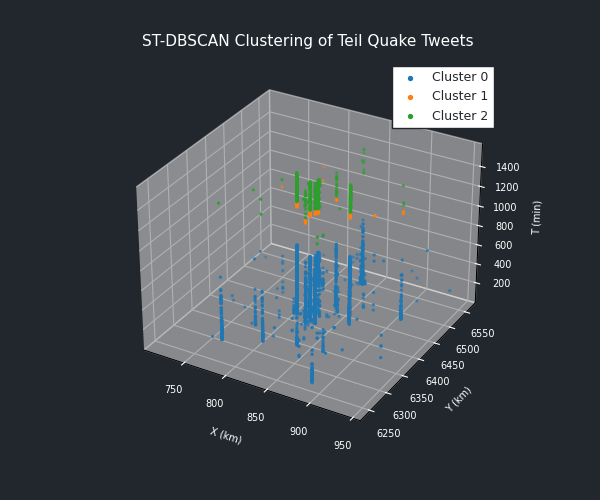

In [10]:
# Plot tweets in 3D
plt.clf()

ax_cube = plt.axes(projection='3d')
# Select tweets without noise
tweets_ = tweets[tweets.index.get_level_values(0) != -1]
for cluster in set(tweets_.index.get_level_values(0)):
    # Select tweets in cluster
    tweets_cluster = tweets_[tweets_.index.get_level_values(0) == cluster]
    # Plot tweets in cluster
    ax_cube.scatter3D(
        tweets_cluster['x_m'],
        tweets_cluster['y_m'],
        tweets_cluster['ts'] / 60,
        s=2,
        color='C{}'.format(cluster),
        label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster)
    )
ax_cube.set_xlabel('x_m')
ax_cube.set_ylabel('y_m')
ax_cube.set_zlabel('ts')

# Set fig size
fig = plt.gcf()
fig.set_size_inches(6, 5)

ax_cube.set_facecolor('#22272e')
ax_cube.get_figure().patch.set_facecolor('#22272e')

# Set title
ax_cube.set_title("ST-DBSCAN Clustering of Teil Quake Tweets", fontsize=11, weight='medium', color='white', pad=10)

ax_cube.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2,
          facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')

m2km = lambda x, _: f'{x/1000:g}'
ax_cube.xaxis.set_major_formatter(m2km)
ax_cube.yaxis.set_major_formatter(m2km)

# Set axis labels
ax_cube.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
ax_cube.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')
ax_cube.set_zlabel("T (min)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
ax_cube.tick_params(axis='x', colors='white', labelsize=7)
ax_cube.tick_params(axis='y', colors='white', labelsize=7)
ax_cube.tick_params(axis='z', colors='white', labelsize=7)

plt.show()

In [11]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')
france = france.to_crs("EPSG:2154")

Cluster -1: 731 tweets
Cluster 0: 3644 tweets
Cluster 1: 67 tweets
Cluster 2: 575 tweets


Text(0.02, 0.98, '$eps1=90$ km\n$eps2=10$ min\n$min_{samples}=22$ tweets')

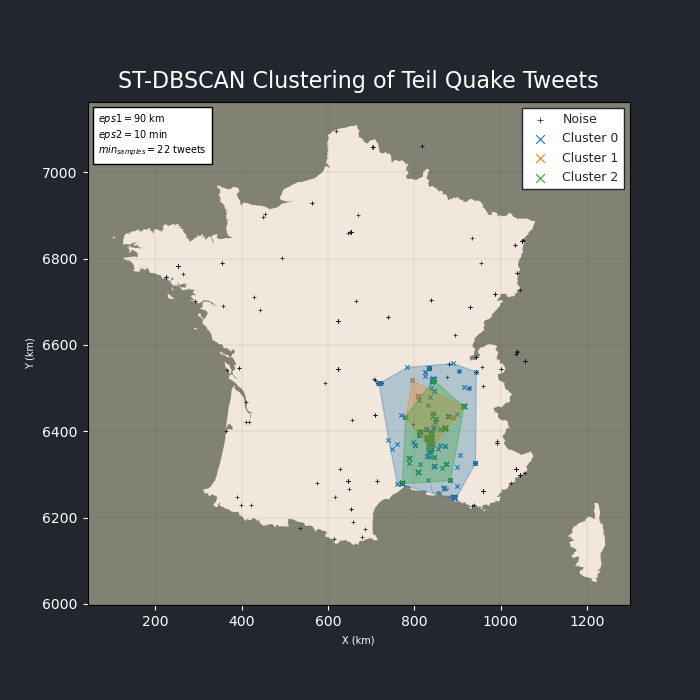

In [12]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')
base.get_figure().patch.set_facecolor('#22272e')

# Plot tweets with color based on cluster
for cluster in tweets.index.get_level_values(0).unique():
    # Number of tweets in cluster
    num_tweets = len(tweets[tweets.index.get_level_values(0) == cluster])
    # Check whether cluster id exists in hulls
    if cluster in hulls.cluster.values or cluster == -1:
        print("Cluster {}: {} tweets".format(cluster, num_tweets))
        tweets[tweets.index.get_level_values(0) == cluster].plot(
            ax=base,
            markersize=6 if cluster == -1 else 10,
            label='Noise' if cluster == -1 else 'Cluster {}'.format(cluster),
            marker='x' if cluster != -1 else '+',
            color='#161819' if cluster == -1 else 'C{}'.format(cluster),
            linewidth=0.5 if cluster == -1 else 0.8,
        )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster),
        edgecolor='C{}'.format(cluster),
        linewidth=1
    )

# Set title
base.set_title("ST-DBSCAN Clustering of Teil Quake Tweets", fontsize=16, weight='medium', color='white', pad=10)

# Set legend
base.legend(loc='best', fontsize=9, labelcolor='#22272e', markerscale=2, facecolor='white', title_fontsize=14, fancybox=False, framealpha=1, edgecolor='#22272e')
# bbox_to_anchor=(1.23, 1.01

# Add grid
base.grid(color='#161819', linestyle='-', linewidth=0.2, alpha=0.3)

# Change tick labels
m2km = lambda x, _: f'{x/1000:g}'
base.xaxis.set_major_formatter(m2km)
base.yaxis.set_major_formatter(m2km)

# Set axis labels
base.set_xlabel("X (km)", fontsize=7, labelpad=5, color='white')
base.set_ylabel("Y (km)", fontsize=7, labelpad=5, color='white')

# Set axis ticks color
base.tick_params(axis='x', colors='white')
base.tick_params(axis='y', colors='white')

textstr = '\n'.join((
    r'$eps1=%.0f$ km' % (eps1_terrain / 1_000, ),
    r'$eps2=%d$ min' % (eps2, ),
    r'$min_{samples}=%d$ tweets' % (min_samples, )))

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white')

# place a text box in upper left in axes coords
base.text(0.02, 0.98, textstr, transform=base.transAxes, fontsize=7,
        verticalalignment='top', bbox=props)

In [13]:
# Save figures
ax_cube.get_figure().savefig('./images/st_dbscan_3d.png', dpi=300, bbox_inches='tight', facecolor=ax_cube.get_figure().get_facecolor(), edgecolor='none')
base.get_figure().savefig('./images/st_dbscan.png', dpi=300, bbox_inches='tight', facecolor=base.get_figure().get_facecolor(), edgecolor='none')

In [14]:
# Export tweets to geojson
tweets.to_file('../data/tweets_stdbscan.geojson', driver='GeoJSON')

# Export hulls to geojson
hulls.to_file('../data/hulls_stdbscan.geojson', driver='GeoJSON')

> Made with ♥ by Léa, Romain and Salaheddine.